In [1]:
import pandas as pd
import torch

In [2]:
df = pd.read_csv('voice.csv')
df

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3163,0.131884,0.084734,0.153707,0.049285,0.201144,0.151859,1.762129,6.630383,0.962934,0.763182,...,0.131884,0.182790,0.083770,0.262295,0.832899,0.007812,4.210938,4.203125,0.161929,female
3164,0.116221,0.089221,0.076758,0.042718,0.204911,0.162193,0.693730,2.503954,0.960716,0.709570,...,0.116221,0.188980,0.034409,0.275862,0.909856,0.039062,3.679688,3.640625,0.277897,female
3165,0.142056,0.095798,0.183731,0.033424,0.224360,0.190936,1.876502,6.604509,0.946854,0.654196,...,0.142056,0.209918,0.039506,0.275862,0.494271,0.007812,2.937500,2.929688,0.194759,female
3166,0.143659,0.090628,0.184976,0.043508,0.219943,0.176435,1.591065,5.388298,0.950436,0.675470,...,0.143659,0.172375,0.034483,0.250000,0.791360,0.007812,3.593750,3.585938,0.311002,female


In [3]:
x = df.values[:, :-1]
x = torch.tensor(x.astype('float32'))
y = df.values[:, -1]
print('y', y)
y[y == 'male'] = 0
y[y == 'female'] = 1
print('y', y)
y = torch.tensor(y.astype('float32'))

y ['male' 'male' 'male' ... 'female' 'female' 'female']
y [0 0 0 ... 1 1 1]


In [4]:
from torch.utils.data import random_split, DataLoader, Dataset

In [5]:
class TensorDataset(Dataset):
    def __init__(self, *tensors, mu, std):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors), "Size mismatch between tensors"
        self.tensors = tensors
        self.mu = mu
        self.std = std

    def __getitem__(self, index):
        x = self.tensors[0][index]
        x = (x - self.mu) / self.std
        y = self.tensors[1][index]
        return (x, y)

    def __len__(self):
        return self.tensors[0].size(0)

In [6]:
train_size = round(len(x) * 0.7)
test_size = len(x) - train_size
train_idx, test_idx = random_split(range(len(x)), [train_size, test_size])
mu = x[train_idx].mean(dim=0)
std = x[train_idx].std(dim=0)

In [7]:
dataset_train = TensorDataset(x[train_idx], y[train_idx], mu=mu, std=std)
dataset_test = TensorDataset(x[test_idx], y[test_idx], mu=mu, std=std)

In [8]:
print('train', len(dataset_train))
print('test', len(dataset_test))

train 2218
test 950


In [9]:
batch_size = 64
train_data = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
test_data = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

In [10]:
from torch import nn

latent_dim = 5

class VoiceEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(20, 12),
            nn.ReLU(True),
            nn.BatchNorm1d(12),
            nn.Linear(12, 7),
            nn.ReLU(True),
            nn.BatchNorm1d(7),
            nn.Linear(7, latent_dim),
        )
    
    def forward(self, x):
        return self.encoder(x)

class VoiceDownStream(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = VoiceEncoder()
        
        w_layers = [nn.Linear(latent_dim, latent_dim, bias=False) for _ in range(2)]
        self.w_layers = nn.Sequential(*w_layers)
        
        self.down = nn.Sequential(
            nn.Linear(latent_dim, 3),
            nn.ReLU(True),
            nn.BatchNorm1d(3),
            nn.Linear(3, 1),
        )

    def forward(self, x):
        encode = self.encoder(x)
        encode = self.w_layers(encode)
        out = self.down(encode)
        return torch.sigmoid(out)

In [11]:
device = torch.device('cuda:2')
model = VoiceDownStream().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-3)

In [12]:
# test model
test_x = torch.rand(16, 20).to(device)
model(test_x).shape

torch.Size([16, 1])

In [13]:
ckpt = torch.load('ckpts/irmae_dim5.pt')
model.load_state_dict(ckpt, False)

for p in model.encoder.parameters():
    p.requires_grad = False
for p in model.w_layers.parameters():
    p.requires_grad = False

In [14]:
from tqdm import tqdm
def train(model, data, epoch, criterion, optimizer, device, is_tqdm=False):
    model.train()
    loss_list = []
    acc_count = 0

    loader = enumerate(data)
    if is_tqdm:
        loader = tqdm(loader, total=len(data))
    for i, (batch, label) in loader:
        batch = batch.to(device)
        label = label.to(device).float()

        optimizer.zero_grad()
        score = model(batch).squeeze() # predict the label
        loss = criterion(score, label) # calculate error
        loss_list.append(loss.item())
        
        pred = score.round()
        acc_count += pred.eq(label).sum().item()
        
        loss.backward()  # back-propagation
        optimizer.step() # gradient descent

    acc = acc_count / (len(data) * data.batch_size) * 100
    return sum(loss_list) / len(loss_list), acc

def test(model, data, criterion, device, is_tqdm=False):
    model.eval()
    loss_list = []

    acc_count = 0
    loader = enumerate(data)
    if is_tqdm:
        loader = tqdm(loader, total=len(data))
    for i, (batch, label) in loader:
        batch = batch.to(device)
        label = label.to(device).float()

        score = model(batch).squeeze()
        loss = criterion(score, label)
        loss_list.append(loss.item())

        pred = score.round()
        acc_count += pred.eq(label).sum().item()

    acc = acc_count / (len(data) * data.batch_size) * 100
    return sum(loss_list) / len(loss_list), acc

In [15]:
import matplotlib.pyplot as plt

class Meter:
    def __init__(self):
        self.train_loss_list = []
        self.train_acc_list = []
        self.val_loss_list = []
        self.val_acc_list = []
    
    def update(self, train_loss, train_acc, val_loss, val_acc):
        self.train_loss_list.append(train_loss)
        self.train_acc_list.append(train_acc)
        self.val_loss_list.append(val_loss)
        self.val_acc_list.append(val_acc)
    
    def plot(self):
        x = range(len(self.train_loss_list))
        plt.figure(figsize=(12, 4))
        plt.plot(x, self.train_loss_list)
        plt.plot(x, self.val_loss_list, color='r')
        plt.legend(['train_loss', 'val_loss'])
        plt.show()
        plt.figure(figsize=(12, 4))
        plt.plot(x, self.train_acc_list)
        plt.plot(x, self.val_acc_list, color='r')
        plt.legend(['train_acc', 'val_acc'])
        plt.show()

In [16]:
from torch.optim.lr_scheduler import StepLR

max_epoch = 90
step_size = 30
log_interval = 5

scheduler = StepLR(optimizer, step_size=step_size, gamma=0.2)

meter = Meter()

for epoch in range(1, max_epoch + 1):
    if epoch % log_interval == 0:
        tqdm.write('==========Train Epoch {}=========='.format(epoch))
    train_loss, train_acc = train(model, train_data, epoch, criterion, optimizer, device)
    test_loss, test_acc = test(model, test_data, criterion, device)
    scheduler.step()
    
    meter.update(train_loss, train_acc, test_loss, test_acc)
    
    if epoch % log_interval == 0:
        print('Train loss: {:.04f} acc: {:.02f} - Test loss: {:.04f} acc: {:.02f}'.format(
            train_loss, train_acc, test_loss, test_acc
        ))

==========Train Epoch 5==========
Train loss: 0.5332 acc: 86.65 - Test loss: 0.5479 acc: 90.31
==========Train Epoch 10==========
Train loss: 0.4697 acc: 88.79 - Test loss: 0.5163 acc: 91.56
==========Train Epoch 15==========
Train loss: 0.4450 acc: 89.11 - Test loss: 0.5215 acc: 91.56
==========Train Epoch 20==========
Train loss: 0.4685 acc: 88.04 - Test loss: 0.5366 acc: 91.67
==========Train Epoch 25==========
Train loss: 0.4558 acc: 89.69 - Test loss: 0.4989 acc: 90.83
==========Train Epoch 30==========
Train loss: 0.4408 acc: 89.38 - Test loss: 0.5671 acc: 90.83
==========Train Epoch 35==========
Train loss: 0.4427 acc: 89.15 - Test loss: 0.5175 acc: 91.35
==========Train Epoch 40==========
Train loss: 0.4287 acc: 89.73 - Test loss: 0.5083 acc: 91.46
==========Train Epoch 45==========
Train loss: 0.4497 acc: 89.38 - Test loss: 0.5202 acc: 91.04
==========Train Epoch 50==========
Train loss: 0.4553 acc: 89.64 - Test loss: 0.5112 acc: 91.88
==========Train Epoch 55==========
Train 

In [24]:
(0.2054 + 0.2111 + 0.4991) / 3

0.30519999999999997

- dim2  
Train loss: 0.4713 acc: 77.90 - Test loss: 0.4781 acc: 76.77  
Train loss: 0.4641 acc: 78.35 - Test loss: 0.4667 acc: 76.98  
Train loss: 0.4718 acc: 77.54 - Test loss: 0.4586 acc: 77.50
- dim3  
Train loss: 0.2793 acc: 90.00 - Test loss: 0.2670 acc: 89.79  
Train loss: 0.2929 acc: 89.20 - Test loss: 0.2763 acc: 89.58  
Train loss: 0.2842 acc: 89.96 - Test loss: 0.2729 acc: 89.58
- dim5  
Train loss: 0.2103 acc: 91.70 - Test loss: 0.2054 acc: 92.40  
Train loss: 0.2439 acc: 91.29 - Test loss: 0.2111 acc: 92.81  
Train loss: 0.4371 acc: 89.96 - Test loss: 0.4991 acc: 90.73

In [18]:
# torch.save(model.state_dict(), 'ckpts/ae20,12,7,5_lr1e-3_l0.0925.pt')

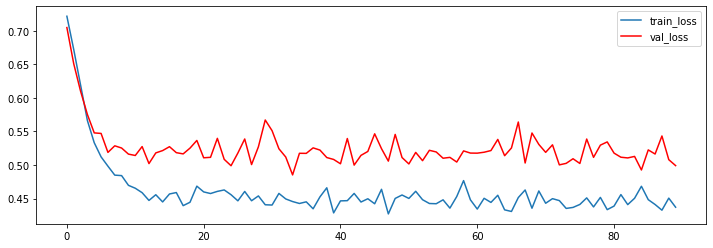

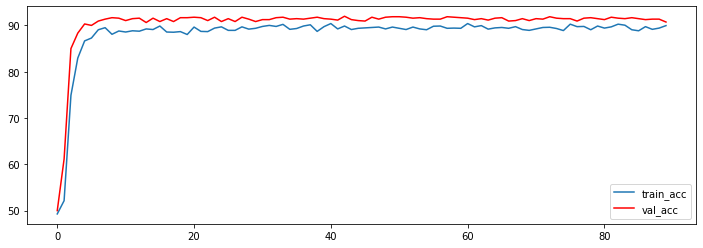

In [19]:
meter.plot()

In [20]:
# use Train loss: 0.1522 - Test loss: 0.1231

- model5,1 lr1e-2 step50 gamma0.2  
Train loss: 0.5245 acc: 71.96 - Test loss: 0.5274 acc: 72.19  
- model5,3,1 bn+relu step20 gamma0.2  
Train loss: 0.2121 acc: 91.56 - Test loss: 0.1693 acc: 93.02  
Train loss: 0.2021 acc: 92.01 - Test loss: 0.1849 acc: 92.92  